In [1]:
from datasets import load_dataset
import os
import torch
import torch.optim as optim
from utils.cnn_rnn_hybrid_model import *
from utils.cnn_rnn_hybrid_utils import *
from utils.utils import *

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

Dataloaders

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Model

## Hybrid Model with Last State sentence representation
Part 3.1 Accuracy: 0.7158, Part 3.2 Accuracy: 0.7477

In [ ]:
model = CNNRNNHybridModel(
    embed_dim=350,  # Embedding dimension, matching Word2vec or GloVe
    rnn_hidden_dim=2048,
    num_classes=1, # Binary classification
    kernel_size=3, # Size of the kernel for the CNN layer
    fc_hidden_dim=2048,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
    pooling_mode="last_state"
)

In [17]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

Epoch   1/100, Loss: 0.6936, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6936, Accuracy: 0.5000
Epoch   3/100, Loss: 0.6903, Accuracy: 0.6173
Model saved.
Epoch   4/100, Loss: 0.6445, Accuracy: 0.6670
Model saved.
Epoch   5/100, Loss: 0.5645, Accuracy: 0.6801
Model saved.
Epoch   6/100, Loss: 0.4853, Accuracy: 0.6979
Model saved.
Epoch   7/100, Loss: 0.4290, Accuracy: 0.7111
Model saved.
Epoch   8/100, Loss: 0.3711, Accuracy: 0.7233
Model saved.
Epoch   9/100, Loss: 0.3327, Accuracy: 0.7270
Model saved.
Epoch  10/100, Loss: 0.2808, Accuracy: 0.7298
Model saved.
Epoch  11/100, Loss: 0.2459, Accuracy: 0.7242
Epoch  12/100, Loss: 0.2190, Accuracy: 0.7195
Epoch  13/100, Loss: 0.1948, Accuracy: 0.7186
Epoch  14/100, Loss: 0.1746, Accuracy: 0.7233
Epoch  15/100, Loss: 0.1485, Accuracy: 0.7223
Epoch  16/100, Loss: 0.1383, Accuracy: 0.7139
Epoch  17/100, Loss: 0.1205, Accuracy: 0.7139
Epoch  18/100, Loss: 0.1068, Accuracy: 0.7176
Epoch  19/100, Loss: 0.0991, Accuracy: 0.7148
Epoch  20

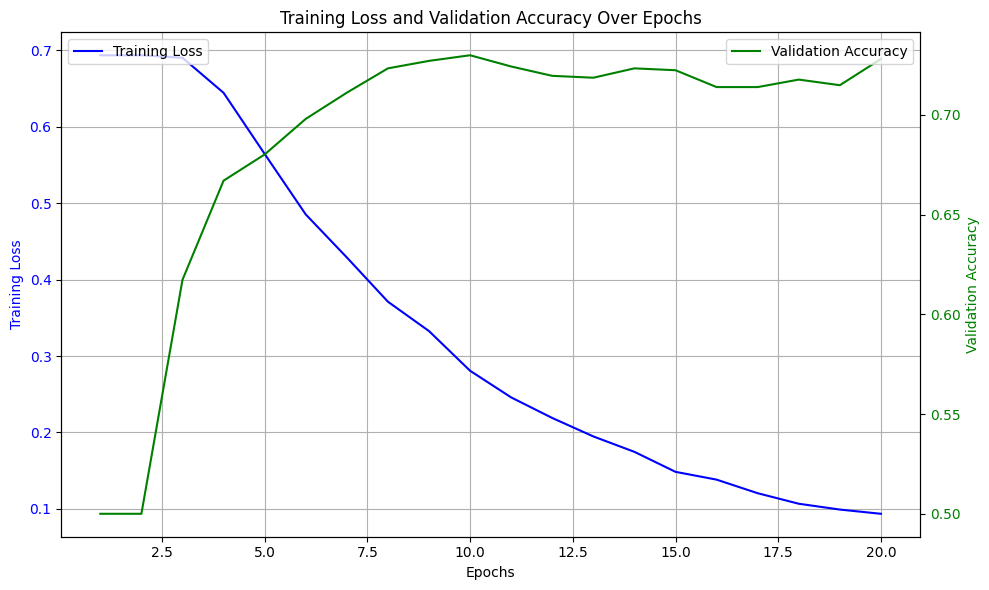

In [18]:
plot_training_progress(train_losses, val_accuracies)

In [19]:
last_state_rnn_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7495


In [20]:
print(f"Test accuracy: {last_state_rnn_test_accuracy:.4f}")

Test accuracy: 0.7495


## Hybrid Model with Mean Max sentence representation
Part 3.1 Accuracy: 0.7488, Part 3.2 Accuracy: 0.7364

In [21]:
model = CNNRNNHybridModel(
    embed_dim=350,  # Embedding dimension, matching Word2vec or GloVe
    rnn_hidden_dim=2048,
    num_classes=1,  # Binary classification
    kernel_size=3,  # Size of the kernel for the CNN layer
    fc_hidden_dim=2048,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
    pooling_mode="mean_max"
)

In [22]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

Epoch   1/100, Loss: 0.6934, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6890, Accuracy: 0.5807
Model saved.
Epoch   3/100, Loss: 0.6277, Accuracy: 0.6313
Model saved.
Epoch   4/100, Loss: 0.5173, Accuracy: 0.6876
Model saved.
Epoch   5/100, Loss: 0.4001, Accuracy: 0.7026
Model saved.
Epoch   6/100, Loss: 0.3158, Accuracy: 0.7026
Epoch   7/100, Loss: 0.2420, Accuracy: 0.7139
Model saved.
Epoch   8/100, Loss: 0.1869, Accuracy: 0.6979
Epoch   9/100, Loss: 0.1547, Accuracy: 0.7008
Epoch  10/100, Loss: 0.1246, Accuracy: 0.6979
Epoch  11/100, Loss: 0.0984, Accuracy: 0.6970
Epoch  12/100, Loss: 0.0863, Accuracy: 0.7026
Epoch  13/100, Loss: 0.0595, Accuracy: 0.6998
Epoch  14/100, Loss: 0.0564, Accuracy: 0.7017
Epoch  15/100, Loss: 0.0498, Accuracy: 0.6932
Epoch  16/100, Loss: 0.0466, Accuracy: 0.6857
Epoch  17/100, Loss: 0.0363, Accuracy: 0.6867
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


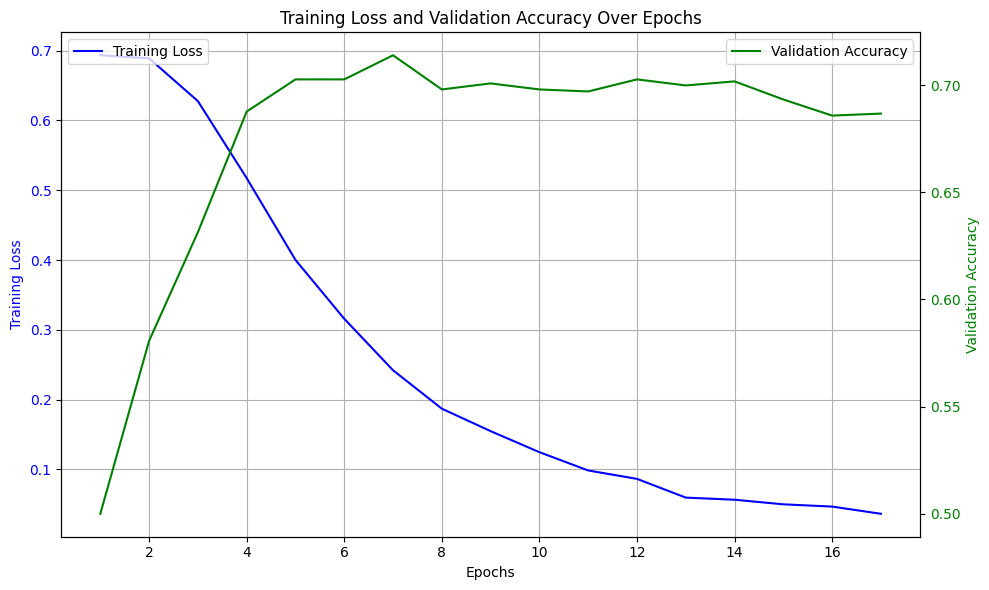

In [23]:
plot_training_progress(train_losses, val_accuracies)

In [24]:
mean_max_rnn_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7111


In [25]:
print(f"Test accuracy: {mean_max_rnn_test_accuracy:.4f}")

Test accuracy: 0.7111


# Results

In [26]:
print(f"Hybrid model with Default RNN Test Accuracy:      {last_state_rnn_test_accuracy:.4f}")
print(f"Hybrid model with Last State Test Accuracy:       {mean_max_rnn_test_accuracy:.4f}")

Hybrid model with Default RNN Test Accuracy:      0.7495
Hybrid model with Last State Test Accuracy:       0.7111
